### Notebook to make figures for CLOUD compatible in paper
TODO for paper figures:
1. Plot test loss over 2,000 patches
2. Plot training losses among selected pairs
3. Compute cossine sim at decoder layer

In [2]:
%matplotlib inline 
import os
import gc
import sys
import glob
import json
import math
import pickle
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.contrib.data import parallel_interleave
from tensorflow.python.keras.models import Model

import seaborn as sns
import matplotlib as mlp
import matplotlib.pyplot as plt
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
libdir = '/home/tkurihana/scratch-midway2/clouds/src_analysis/lib_hdfs'
sys.path.insert(1,os.path.join(sys.path[0],libdir))
from analysis_lib import get_rand_colors

------------------
### 1. Visualize heatmap for test loss over 2,000 patches

In [4]:
inferencedir = "/home/tkurihana/rotate_invariant/paper/modis_inference/inference"

In [5]:
def testloss_loader(filename=None, n=3):
    with open(filename, 'r') as f:
        lines = f.read()
        data = []
        for line in lines.split('\n'):
            tmp = np.zeros((n))
            if len(line) > 0:
                for idx, i in enumerate(line.split(',')):
                    tmp[idx] = float(i.rstrip('\n'))
                data.append(np.expand_dims(np.array(tmp),axis=0))
    return np.concatenate(data, axis=0 )

In [6]:
expname_table = pd.read_csv("./paper_gridsearch1e-2.csv",
                            index_col=0, 
                           )

In [7]:
expname_table

,1,8,10,20,50,80
0.0,66733069.0,66773101.0,66728443.0,66782306.0,66795732.0,66910202
0.1,66773734.0,66773377.0,66773377.0,66796086.0,66835247.0,66982174
0.2,6908492.0,6908499.0,6972805.0,6972803.0,6972799.0,6908486
0.4,6908493.0,6908502.0,6972753.0,6972773.0,6976430.0,6938952
0.8,6908496.0,6908503.0,6972751.0,6972757.0,6972779.0,6908488
1.6,6908497.0,66782223.0,66782225.0,6939152.0,6939149.0,6910179
3.2,66733097.0,3528207.0,66728938.0,6939151.0,6939150.0,6908490
6.4,66733149.0,66773017.0,66728488.0,66835542.0,66860658.0,6945622
12.8,NaN,NaN,NaN,66782309.0,66795754.0,66910308
25.6,NaN,NaN,NaN,66795759.0,66795758.0,66910242


- Load and compute losses 

In [7]:
##
lambda_res = expname_table.columns.to_numpy()
lambda_inv = expname_table.index.to_numpy()
loss_array = np.zeros((len(lambda_inv), len(lambda_res))) # restoration loss


for idx, inv in enumerate(lambda_inv):
    for jdx, res in enumerate(lambda_res):
        expname = expname_table.loc[inv,res] # float
        if np.isnan(expname):
            loss_array[idx, jdx] = np.nan
        else:
            try:
                str_expname = str(int(expname))
                filename = glob.glob(os.path.join(inferencedir, f"*{str_expname}*.txt"))[0]
                losses = testloss_loader(filename, n=3) # assume np.array([Inv, Res, Spars])
                loss = losses[0][1] # only store
                loss_array[idx, jdx] = loss
            except:
                stop
                pass
            

In [8]:
loss_df = pd.DataFrame(loss_array)
loss_df.columns =lambda_res
loss_df.index =lambda_inv

##### divide first row and ther other row

In [124]:
loss_df.iloc[:,:]

,1,8,10,20,50,80
0.0,0.002877,0.002102,0.002035,0.001809,0.001775,0.001838
0.1,0.003114,0.002045,0.002045,0.001813,0.001814,0.001716
0.2,0.007866,0.002542,0.004550,0.006169,0.002206,0.002113
0.4,0.008187,0.002536,0.002590,0.002304,0.002140,0.002078
0.8,0.008970,0.002609,0.002496,0.002363,0.002167,0.002500
1.6,0.009214,0.002245,0.002272,0.002677,0.002177,0.002088
3.2,0.004968,0.002340,0.002843,0.002455,0.002169,0.002094
6.4,0.005019,0.002949,0.002415,0.002100,0.001859,0.002561
12.8,NaN,NaN,NaN,0.002981,0.001915,0.001841
25.6,NaN,NaN,NaN,0.002488,0.002085,0.001996


In [125]:
loss_df.iloc[1:,:]

,1,8,10,20,50,80
0.1,0.003114,0.002045,0.002045,0.001813,0.001814,0.001716
0.2,0.007866,0.002542,0.004550,0.006169,0.002206,0.002113
0.4,0.008187,0.002536,0.002590,0.002304,0.002140,0.002078
0.8,0.008970,0.002609,0.002496,0.002363,0.002167,0.002500
1.6,0.009214,0.002245,0.002272,0.002677,0.002177,0.002088
3.2,0.004968,0.002340,0.002843,0.002455,0.002169,0.002094
6.4,0.005019,0.002949,0.002415,0.002100,0.001859,0.002561
12.8,NaN,NaN,NaN,0.002981,0.001915,0.001841
25.6,NaN,NaN,NaN,0.002488,0.002085,0.001996
32.0,NaN,NaN,NaN,NaN,NaN,0.001939


In [283]:
# old + new
loss_df.iloc[1:,:]

,1,8,10,20,50,80
0.1,0.003060,0.002038,0.002038,0.001816,0.001794,0.001738
0.2,0.007866,0.002542,0.004550,0.006169,0.002206,0.002113
0.4,0.008187,0.002536,0.002590,0.002304,0.002140,0.002078
0.8,0.008970,0.002609,0.002496,0.002363,0.002167,0.002500
1.6,0.009214,0.002217,0.002146,0.002677,0.002177,0.002088
3.2,0.004988,0.002358,0.002284,0.002455,0.002169,0.002094
6.4,0.005021,0.002739,0.002434,0.002067,0.001855,0.002561
12.8,NaN,NaN,NaN,0.002277,0.001918,0.001978
25.6,NaN,NaN,NaN,0.002488,0.003338,0.002078
32.0,NaN,NaN,NaN,NaN,NaN,0.001943


In [9]:
# div
df_ratio = loss_df.iloc[1:,:].div(loss_df.iloc[0,:])

In [127]:
df_ratio

,1,8,10,20,50,80
0.1,1.082479,0.972681,1.004880,1.002388,1.022005,0.933687
0.2,2.733969,1.208966,2.235800,3.410262,1.242785,1.149877
0.4,2.845497,1.206116,1.272575,1.273832,1.205524,1.130585
0.8,3.117602,1.240877,1.226546,1.306518,1.220445,1.360526
1.6,3.202567,1.068059,1.116224,1.480040,1.226320,1.136406
3.2,1.726869,1.113242,1.397039,1.357077,1.221861,1.139507
6.4,1.744305,1.402811,1.186538,1.160699,1.047384,1.393832
12.8,NaN,NaN,NaN,1.647862,1.078503,1.002081
25.6,NaN,NaN,NaN,1.375168,1.174214,1.086222
32.0,NaN,NaN,NaN,NaN,NaN,1.055328


In [285]:
# old + new
df_ratio

,1,8,10,20,50,80
0.1,1.057102,0.974360,1.001494,1.007829,1.013883,0.945538
0.2,2.717272,1.215150,2.235800,3.424211,1.246856,1.149877
0.4,2.828118,1.212285,1.272575,1.279042,1.209473,1.130585
0.8,3.098561,1.247223,1.226546,1.311862,1.224442,1.360526
1.6,3.183008,1.059942,1.054648,1.486093,1.230336,1.136406
3.2,1.722951,1.127153,1.122440,1.362628,1.225863,1.139507
6.4,1.734602,1.309560,1.195963,1.147148,1.048103,1.393832
12.8,NaN,NaN,NaN,1.263747,1.084004,1.076109
25.6,NaN,NaN,NaN,1.380767,1.886310,1.130683
32.0,NaN,NaN,NaN,NaN,NaN,1.057482


In [10]:
np.min(df_ratio.min())

0.9455378937379152

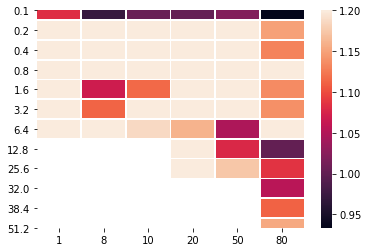

In [130]:
plt.figure()
sns.heatmap(df_ratio, linewidths=0.75, vmin=np.min(df_ratio.min()), vmax=1.2)
plt.show()

-------------------------
### 3. Compute cossine sim at output layer

#### 3.1 prep a layer for cossim computation

In [11]:
def rotate_fn(images, angles):
    """
    images : 4d tensor [batch, height, width channel]
      original oprion - nearest. Additional: biilnear
    """
    rotated_tensor_images = tf.contrib.image.transform(
      images,
      tf.contrib.image.angles_to_projective_transforms(
        angles, tf.cast(tf.shape(images)[1], tf.float32), 
            tf.cast(tf.shape(images)[2], tf.float32)
        ),
    )
     #interpolation='BILINEAR'
    return rotated_tensor_images

In [12]:
def load_latest_model(model_dir, mtype):
    #TODO add restart model dir and restart argument?
    latest = 0, None
    # get trained wegiht 
    for m in os.listdir(model_dir):
        if ".h5" in m and mtype in m:
            epoch = int(m.split("-")[1].replace(".h5", ""))
            latest = max(latest, (epoch, m))

    epoch, model_file = latest

    if not os.listdir(model_dir):
        raise NameError("no directory. check model path again")

    print(" Load {} at {} epoch".format(mtype, epoch))
    model_def = model_dir+'/'+mtype+'.json'
    model_weight = model_dir+'/'+mtype+'-'+str(epoch)+'.h5'
    with open(model_def, "r") as f:
        model = tf.keras.models.model_from_json(f.read())
    model.load_weights(model_weight)
    return model

In [13]:
def data_extractor_resize_fn(filelist,prefetch=1,height=32,width=32,channel=6,read_threads=4, distribute=(1, 0)):
    def parser(ser):
        """
        Decode & Pass datast in tf.record
        *Cuation*
        floating point: tfrecord data ==> tf.float64
        """
        features = {
            "shape": tf.FixedLenFeature([3], tf.int64),
            "patch": tf.FixedLenFeature([], tf.string),
            "filename": tf.FixedLenFeature([], tf.string),
            "coordinate": tf.FixedLenFeature([2], tf.int64),
        }
        decoded = tf.parse_single_example(ser, features)
        patch = tf.reshape(
            tf.decode_raw(decoded["patch"], tf.float64), decoded["shape"]
        )
        # conversion of tensor
        patch = tf.image.resize_images(patch, (height, width))
        patch = tf.cast(patch, tf.float64)
        return patch
    
    dataset = (
        tf.data.Dataset.list_files(filelist, shuffle=True)
            .shard(*distribute)
            .apply(
            parallel_interleave(
                lambda f: tf.data.TFRecordDataset(f).map(parser),
                cycle_length=read_threads,
                sloppy=True,
            )
        )
    )
    iterator = dataset.make_one_shot_iterator()

    next_element = iterator.get_next()
    patches_list = []
    with tf.Session() as sess:
        try:
            while True:
                patch = sess.run(next_element)
                patches_list.append(patch)
        except tf.errors.OutOfRangeError:
            print("OutOfRage --> finish process")
            pass
    return patches_list

In [14]:
def copy_rot_fn(patches, height=None, width=None, ch=None, copy_size=None):
    img_list = []
    for patch in patches:
        img_list.extend([np.reshape(patch, (1,height,width,ch))])
        img_list.extend([ np.expand_dims(np.copy(patch.reshape(height,width,ch)), axis=0) 
                     for i in range(copy_size-1)])
    imgs = np.concatenate(img_list, axis=0)
    print(imgs.shape)
    
    radians = []
    for j in range(patches.shape[0]):
        radians.extend([i*math.pi/180 for i in np.linspace(0,360,copy_size+1) ][:-1] )
    print(len(radians))
    rimgs_tf = rotate_fn(imgs, angles=radians)
    rtest_imgs = tf.keras.backend.eval(rimgs_tf)
    del imgs, rimgs_tf
    return rtest_imgs

In [15]:
def comp_dec_result(encs, decoder, layer_name="leaky_re_lu_27"): 
    decoder_results = {}
    model = decoder
    ### processing ###
    #layer_names = [layer.name for layer in model.layers]
    #for layer_name in layer_names[1:]:
        #if 're_lu' in layer_name:
    tmp = Model(inputs=model.input, outputs=model.get_layer(layer_name).output) 
    decoder_results[layer_name] = tmp.predict(encs)
    return decoder_results

In [16]:
def resize_image_fn(imgs,height=32, width=32):
    """Resize images from (#batch,H',W',C) --> (#batch,H,W,C)
    """
    reimgs = tf.image.resize_images(imgs, (height, width))
    return reimgs

- Load test tfrecord image

In [257]:
test_databasedir='/project2/foster/clouds/data/clouds_laads_multiprocessed_2000_2018_band28_29_31_circle_2'

In [258]:
filelist = glob.glob(os.path.join(test_databasedir, '*2-10*'))
len(filelist)

1

In [259]:
patches_list = data_extractor_resize_fn(filelist,height=32,width=32,channel=6 )

Instructions for updating:
Use `tf.data.experimental.parallel_interleave(...)`.
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
OutOfRage --> finish process


- Select random 100 patches

In [20]:
# get random index
rx = np.arange(0,2000,1)
np.random.shuffle(rx)

In [260]:
rx = np.array(
    [1445, 1348,  280,  753, 1508,  356,  257, 1676,  426, 1811, 1334,
       1224,  305,  629, 1997,  808, 1080,  478, 1577,  489, 1132, 1571,
        566, 1507, 1634,  359,  714,  231, 1856, 1880,  303, 1882, 1986,
       1947,  176, 1196, 1118,  622, 1898,  362,  874,  618, 1372,  730,
       1816,  204, 1211, 1293, 1632,  232,  815, 1769, 1453, 1536,  533,
        575,  563,  106,  412,  661, 1724,  195, 1381,  469, 1232, 1074,
       1144,  248,  953, 1098, 1032,  963,  598,  736,  610, 1603, 1813,
       1231,  967,  985,  111, 1900, 1716,  315,  695,  691,  319,  274,
        732, 1472, 1514, 1267,  789,  251,  830, 1103, 1674, 1051, 1746,
       1543]
)

In [22]:
rx[:100]

array([1445, 1348,  280,  753, 1508,  356,  257, 1676,  426, 1811, 1334,
       1224,  305,  629, 1997,  808, 1080,  478, 1577,  489, 1132, 1571,
        566, 1507, 1634,  359,  714,  231, 1856, 1880,  303, 1882, 1986,
       1947,  176, 1196, 1118,  622, 1898,  362,  874,  618, 1372,  730,
       1816,  204, 1211, 1293, 1632,  232,  815, 1769, 1453, 1536,  533,
        575,  563,  106,  412,  661, 1724,  195, 1381,  469, 1232, 1074,
       1144,  248,  953, 1098, 1032,  963,  598,  736,  610, 1603, 1813,
       1231,  967,  985,  111, 1900, 1716,  315,  695,  691,  319,  274,
        732, 1472, 1514, 1267,  789,  251,  830, 1103, 1674, 1051, 1746,
       1543])

In [261]:
## Select and concat
npatches=100

## get image for inferences
simgs_list = [ np.expand_dims(patches_list[i],axis=0) for i in rx[:npatches]] 
simgs = np.concatenate(simgs_list, axis=0)
simgs = simgs.astype(np.float32)
print(simgs.shape)

(100, 32, 32, 6)


In [263]:
## copy and rotate
_,h,w,ch = simgs.shape
copy_size = 12

##
spatches = copy_rot_fn(simgs, height=h, width=w, ch=ch, copy_size=copy_size)

(1200, 32, 32, 6)
1200


#### 3.2 Load model and compute decoder result

In [248]:
## get encs
def _run_decoder(rsimgs,encoder_dict={},decoder_dict={},expname=None, npatches=None, savedir='./pkl'):
    encs = encoder_dict[f"{expname}"].predict(spatches)
    ri_decoder_results = comp_dec_result(encs=encs, decoder=decoder_dict[f"{expname}"],layer_name="leaky_re_lu_27" )
    
    ### save name
    #savedir = './pkl'
    os.makedirs(savedir, exist_ok=True)
    with open(os.path.join(savedir, f'ri_decoder_results{expname}_{npatches}.pkl'), 'wb') as handle:
        pickle.dump(ri_decoder_results, handle, protocol=pickle.HIGHEST_PROTOCOL)
    gc.collect()
    print(f"### End {expname}###")

In [33]:
_expnames = [
66733069,
66773734,
6908492,
6908493,
6908496,
6908497,
66733097,
66733149,
66773101,
66773377,
6908499,
6908502,
6908503,
66782223,
3528207,
66773017,
66728443,
66773377,
6972805,
6972753,
6972751,
66782225,
66728938,
66728488,
66782306,
66796086,
6972803,
6972773,
6972757,
6939152,
6939151,
66835542,
66782309,
66795759,
66795732,
66835247,
6972799,
6976430,
6972779,
6939149,
6939150,
66860658,
66795754,
66795758,
66910202,
66982174,
6908486,
6938952,
6908488,
6910179,
6908490,
6945622,
66910308,
66910242,
67011582,
67011015,
66982182,
]
expnames = [str(i) for i in _expnames]

In [245]:
expnames=[ str(i) for i in [66795762,66909436,66728558]]

In [246]:
# load encoder and decoder
basedir = "/home/tkurihana/rotate_invariant/stepbystep/transform/output_model"
encoder_dict = {}
decoder_dict = {}
for expname in expnames:
    model_dir = os.path.join(basedir, expname)
    encoder_dict[expname] = load_latest_model(model_dir, mtype='encoder')
    decoder_dict[expname] = load_latest_model(model_dir, mtype='decoder')

 Load encoder at 100 epoch
 Load decoder at 100 epoch
 Load encoder at 100 epoch
 Load decoder at 100 epoch
 Load encoder at 100 epoch
 Load decoder at 100 epoch


In [264]:
for ikey in encoder_dict.keys():
    _run_decoder(rsimgs,encoder_dict,decoder_dict,expname=ikey, npatches=npatches, savedir='./pkl')

NameError: name 'rsimgs' is not defined

#### 3.3 Show cossine similarity 

In [17]:
expname_table = pd.read_csv("./paper_gridsearch1e-2.csv",
                            index_col=0, 
                           )

In [18]:
expname_table

,1,8,10,20,50,80
0.0,66733069.0,66773101.0,66728443.0,66782306.0,66795732.0,66910202
0.1,66773734.0,66773377.0,66773377.0,66796086.0,66835247.0,66982174
0.2,6908492.0,6908499.0,6972805.0,6972803.0,6972799.0,6908486
0.4,6908493.0,6908502.0,6972753.0,6972773.0,6976430.0,6938952
0.8,6908496.0,6908503.0,6972751.0,6972757.0,6972779.0,6908488
1.6,6908497.0,66782223.0,66782225.0,6939152.0,6939149.0,6910179
3.2,66733097.0,3528207.0,66728938.0,6939151.0,6939150.0,6908490
6.4,66733149.0,66773017.0,66728488.0,66835542.0,66860658.0,6945622
12.8,NaN,NaN,NaN,66782309.0,66795754.0,66910308
25.6,NaN,NaN,NaN,66795759.0,66795758.0,66910242


#### Summarize extracted data

In [19]:
def comp_means(results, ikey=None):
    result = results[ikey] # (npatches, ncopues)
    deg_mean = np.mean(result, axis=0)
    return deg_mean

In [20]:
def comp_stdvs(results, ikey=None):
    result = results[ikey] # (npatches, ncopues)
    deg_mean = np.std(result, axis=0)
    return deg_mean

In [21]:
def _run_reader(filename):
    # read
    with open(filename, 'rb') as handle:
        decoder_cos_results = pickle.load(handle)
    # mean for copies images
    deg_mean_list = {}
    for ikey in decoder_cos_results.keys():
        deg_mean_list[ikey] =  comp_means(decoder_cos_results, ikey=ikey)
        #print(deg_mean_list[ikey])
    
    # compute average overall patches
    deg_means = []
    for ikey in deg_mean_list.keys():
        """ Assume only one layer i.e output layer
        """
        deg_means = np.mean(deg_mean_list[ikey]) 
    #deg_mean_df = pd.DataFrame(deg_means)
    #deg_mean_df.columns = ['cosine sim']
    #eg_mean_df.index = [ikey for ikey in decoder_cos_results.keys()]
    return deg_means

In [22]:
def _run_sreader(filename):
    # read
    with open(filename, 'rb') as handle:
        decoder_cos_results = pickle.load(handle)
    # mean for copies images
    deg_mean_list = {}
    for ikey in decoder_cos_results.keys():
        deg_mean_list[ikey] =  comp_stdvs(decoder_cos_results, ikey=ikey)
        #print(deg_mean_list[ikey])
    
    # compute average overall patches
    deg_means = []
    for ikey in deg_mean_list.keys():
        """ Assume only one layer i.e output layer
        """
        deg_means = np.mean(deg_mean_list[ikey]) 
    #deg_mean_df = pd.DataFrame(deg_means)
    #deg_mean_df.columns = ['cosine sim']
    #eg_mean_df.index = [ikey for ikey in decoder_cos_results.keys()]
    return deg_means

In [23]:
 expname_table.columns.to_numpy()

array(['1', '8', '10', '20', '50', '80'], dtype=object)

Check cos-sim

In [24]:
alist = []
for idx, inv in enumerate(lambda_inv[:1]):
    for jdx, res in enumerate(lambda_res[:1]):
        expname = expname_table.loc[inv,res] # float
        if np.isnan(expname):
            #deg_means_array[idx, jdx] = np.nan
            pass
        else:
            try:
                str_expname = str(int(expname))
                filename = glob.glob(os.path.join('./pkl', f"ri_decoder_results*{str_expname}*"))[0]
                print(filename)
                with open(filename, 'rb') as handle:
                    alist.append(pickle.load(handle))
            except:
                stop
                pass
            

./pkl/ri_decoder_results66733069_100.pkl


In [42]:
alist[0].keys()

dict_keys(['leaky_re_lu_27'])

In [43]:
a = alist[0]['leaky_re_lu_27']
a.shape

(1200, 32, 32, 6)

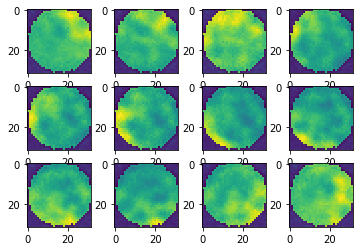

In [44]:
fig = plt.figure()
for i in range(12):
    ii = i+1
    ax = plt.subplot(3,4,ii)
    plt.imshow(a[i,:,:,0])
plt.show()

In [45]:
from sklearn.metrics.pairwise import cosine_similarity

In [63]:
aa = a[:12]
aa = np.concatenate([ np.expand_dims(i.ravel(), axis=0) for i in aa], axis=0)
for ii in range(1,12,1):
    cs = cosine_similarity(aa[0].reshape(1,-1),aa[ii].reshape(1,-1))
    print(cs)

[[0.9967034]]
[[0.9915955]]
[[0.98475724]]
[[0.97936034]]
[[0.9772362]]
[[0.9739443]]
[[0.97469336]]
[[0.9795757]]
[[0.9828416]]
[[0.9899744]]
[[0.9966513]]


###### main compute

In [25]:
##
lambda_res = expname_table.columns.to_numpy()
lambda_inv = expname_table.index.to_numpy()
deg_means_array = np.zeros((len(lambda_inv), len(lambda_res)))
deg_stdvs_array = np.zeros((len(lambda_inv), len(lambda_res)))


for idx, inv in enumerate(lambda_inv):
    for jdx, res in enumerate(lambda_res):
        expname = expname_table.loc[inv,res] # float
        if np.isnan(expname):
            deg_means_array[idx, jdx] = np.nan
            deg_stdvs_array[idx, jdx] = np.nan
        else:
            try:
                str_expname = str(int(expname))
                filename = glob.glob(os.path.join('./pkl', f"result_ri_decoder_results*{str_expname}*"))[0]
                print(filename)
                dm = _run_reader(filename)
                deg_means_array[idx, jdx] = dm
                ds = _run_sreader(filename)
                deg_stdvs_array[idx, jdx] = ds
            except:
                stop
                pass
            

./pkl/result_ri_decoder_results66733069_100.pkl
./pkl/result_ri_decoder_results66773101_100.pkl
./pkl/result_ri_decoder_results66728443_100.pkl
./pkl/result_ri_decoder_results66782306_100.pkl
./pkl/result_ri_decoder_results66795732_100.pkl
./pkl/result_ri_decoder_results66910202_100.pkl
./pkl/result_ri_decoder_results66773734_100.pkl
./pkl/result_ri_decoder_results66773377_100.pkl
./pkl/result_ri_decoder_results66773377_100.pkl
./pkl/result_ri_decoder_results66796086_100.pkl
./pkl/result_ri_decoder_results66835247_100.pkl
./pkl/result_ri_decoder_results66982174_100.pkl
./pkl/result_ri_decoder_results6908492_100.pkl
./pkl/result_ri_decoder_results6908499_100.pkl
./pkl/result_ri_decoder_results6972805_100.pkl
./pkl/result_ri_decoder_results6972803_100.pkl
./pkl/result_ri_decoder_results6972799_100.pkl
./pkl/result_ri_decoder_results6908486_100.pkl
./pkl/result_ri_decoder_results6908493_100.pkl
./pkl/result_ri_decoder_results6908502_100.pkl
./pkl/result_ri_decoder_results6972753_100.pkl
.

In [26]:
deg_means_df = pd.DataFrame(deg_means_array)

In [27]:
deg_means_df.columns =lambda_res
deg_means_df.index =lambda_inv

In [28]:
deg_means_df

,1,8,10,20,50,80
0.0,0.978082,0.975354,0.975383,0.974790,0.975046,0.975511
0.1,0.992548,0.981616,0.981616,0.978942,0.977783,0.978109
0.2,0.994847,0.984672,0.984807,0.981163,0.979693,0.979333
0.4,0.996712,0.990164,0.989493,0.985108,0.982634,0.982472
0.8,0.998460,0.994167,0.993122,0.991668,0.988120,0.983320
1.6,0.999358,0.997275,0.996859,0.997710,0.992233,0.992547
3.2,0.999728,0.998316,0.998113,0.996731,0.995069,0.994632
6.4,0.999867,0.999165,0.998979,0.998278,0.997739,0.995104
12.8,NaN,NaN,NaN,0.998647,0.998419,0.998126
25.6,NaN,NaN,NaN,0.999532,0.999068,0.998704


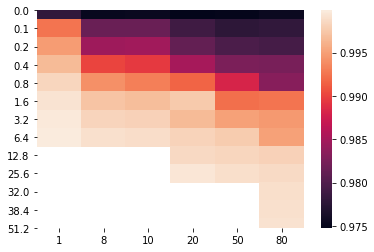

In [62]:
plt.figure()
sns.heatmap(deg_means_df)
plt.show()

In [28]:
deg_stdvs_df = pd.DataFrame(deg_stdvs_array)
deg_stdvs_df.columns =lambda_res
deg_stdvs_df.index =lambda_inv

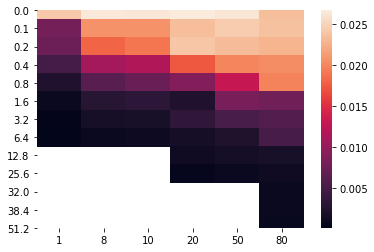

In [74]:
plt.figure()
sns.heatmap(deg_stdvs_df)
plt.show()

### 1 + 3: Loss and Cos-sim

In [29]:
lambda_res = expname_table.columns.to_numpy()
lambda_inv = expname_table.index.to_numpy()

In [224]:
np.min(df_ratio.min())

0.9336872155012405

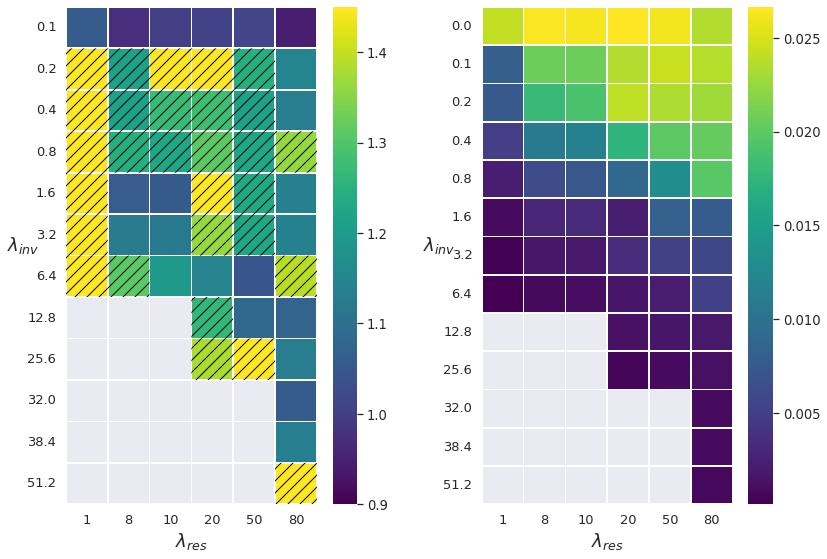

In [286]:
#### config
cmap='viridis'  #'hot'  #'viridis'
vmax=1.45 #1.20
vmin=0.9 #np.min(df_ratio.min())
fsize=13
lsize=18
bs=False

sns.set(font_scale=1.2)
######
fig = plt.figure(figsize=(12,8))
ax = plt.subplot(1,2,1)
sns.heatmap(df_ratio, cmap=cmap, linewidths=0.75, vmin=vmin, vmax=vmax,ax=ax, 
            square=bs,)
ax.set_xticklabels(ax.get_xticklabels(), fontsize = fsize)
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = fsize, va='center')
ax.set_ylim(len(lambda_inv)-1,-0) # align 
ax.set_ylabel(r'$\lambda_{inv}$', fontsize=lsize, rotation='horizontal')
ax.set_xlabel(r'$\lambda_{res}$', fontsize=lsize)
plt.subplots_adjust(bottom=0.15, left=.5)
# add hatch
"""ref: https://stackoverflow.com/questions/55285013/adding-hatches-to-seaborn-heatmap-plot
"""
x= np.arange(len(df_ratio.columns)+1)
y= np.arange(len(df_ratio.index)+1)
zm = np.ma.masked_less(df_ratio.values, 1.2)
plt.pcolor(x, y, zm, hatch='//', alpha=0.)

ax = plt.subplot(1,2,2)
sns.heatmap(deg_stdvs_df,ax=ax,cmap=cmap, square=bs,linewidths=0.75,)
ax.set_xticklabels(ax.get_xticklabels(), fontsize = fsize)
ax.set_yticklabels(lambda_inv,rotation = 0, fontsize = fsize,va='center')
ax.set_ylim(len(lambda_inv),-0)
ax.set_ylabel(r'$\lambda_{inv}$', fontsize=lsize, rotation='horizontal')
ax.set_xlabel(r'$\lambda_{res}$', fontsize=lsize)
plt.subplots_adjust(bottom=0.15,left=.5)

fig.tight_layout()
#plt.subplots_adjust(hspace=0.5)
pdf = PdfPages("./figs/param_search_cloud2.pdf")
plt.savefig(pdf, format='pdf', bbox_inches = 'tight')
plt.show()
pdf.close()
pdf = None

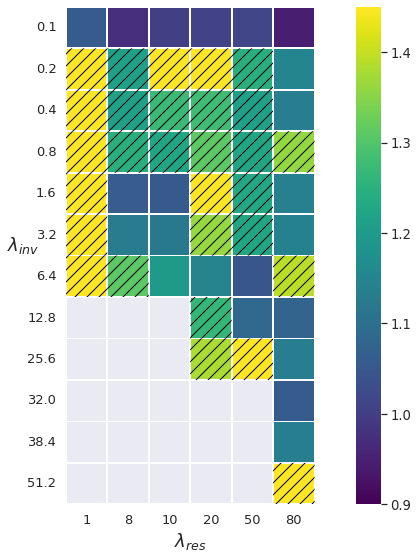

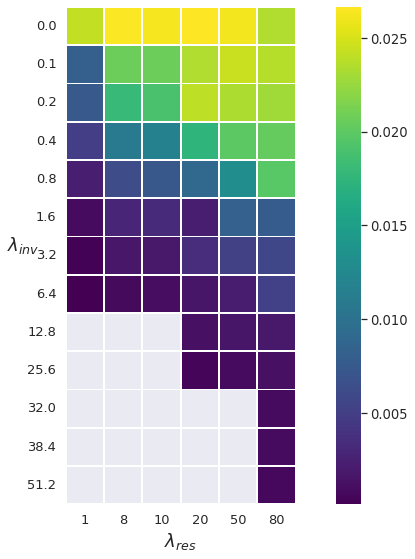

In [289]:
#### config
cmap='viridis'  #'hot'  #'viridis'
vmax=1.45 #1.20
vmin=0.9 #np.min(df_ratio.min())
fsize=13
lsize=18
bs=True

sns.set(font_scale=1.2)
######
fig = plt.figure(figsize=(12,8))
ax = plt.subplot(1,1,1)
sns.heatmap(df_ratio, cmap=cmap, linewidths=0.75, vmin=vmin, vmax=vmax,ax=ax, 
            square=bs,)
ax.set_xticklabels(ax.get_xticklabels(), fontsize = fsize)
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = fsize, va='center')
ax.set_ylim(len(lambda_inv)-1,-0) # align 
ax.set_ylabel(r'$\lambda_{inv}$', fontsize=lsize, rotation='horizontal')
ax.set_xlabel(r'$\lambda_{res}$', fontsize=lsize)
plt.subplots_adjust(bottom=0.15, left=.5)
# add hatch
"""ref: https://stackoverflow.com/questions/55285013/adding-hatches-to-seaborn-heatmap-plot
"""
x= np.arange(len(df_ratio.columns)+1)
y= np.arange(len(df_ratio.index)+1)
zm = np.ma.masked_less(df_ratio.values, 1.2)
plt.pcolor(x, y, zm, hatch='//', alpha=0.)
fig.tight_layout()
#plt.subplots_adjust(hspace=0.5)
pdf = PdfPages("./figs/div_param_search_cloud1.pdf")
plt.savefig(pdf, format='pdf', bbox_inches = 'tight')
plt.show()
pdf.close()
pdf = None


fig = plt.figure(figsize=(12,8))
ax = plt.subplot(1,1,1)
sns.heatmap(deg_stdvs_df,ax=ax,cmap=cmap, square=bs,linewidths=0.75,)
ax.set_xticklabels(ax.get_xticklabels(), fontsize = fsize)
ax.set_yticklabels(lambda_inv,rotation = 0, fontsize = fsize,va='center')
ax.set_ylim(len(lambda_inv),-0)
ax.set_ylabel(r'$\lambda_{inv}$', fontsize=lsize, rotation='horizontal')
ax.set_xlabel(r'$\lambda_{res}$', fontsize=lsize)
plt.subplots_adjust(bottom=0.15,left=.5)

fig.tight_layout()
#plt.subplots_adjust(hspace=0.5)
pdf = PdfPages("./figs/div_param_search_cloud2.pdf")
plt.savefig(pdf, format='pdf', bbox_inches = 'tight')
plt.show()
pdf.close()
pdf = None

In [22]:
x,y

(array([0, 1, 2, 3, 4, 5, 6]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]))

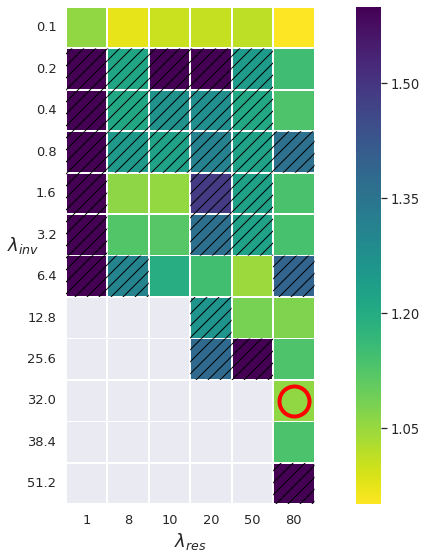

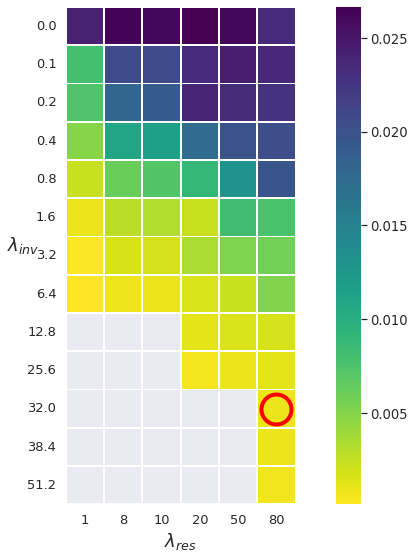

In [31]:
#### config
cmap='viridis_r'  #'hot'  #'viridis'
vmax=1.6 #1.45 #1.20
vmin=0.95 #np.min(df_ratio.min())
fsize=13
lsize=18
bs=True
circle_rad = 15
x1=5.5
y1=9.5
x2=5.5
y2=10.5

sns.set(font_scale=1.2)
######
fig = plt.figure(figsize=(12,8))
ax = plt.subplot(1,1,1)
sns.heatmap(df_ratio, cmap=cmap, linewidths=0.75, vmin=vmin, vmax=vmax,ax=ax, 
            square=bs,)
ax.set_xticklabels(ax.get_xticklabels(), fontsize = fsize)
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = fsize, va='center')
ax.set_ylim(len(lambda_inv)-1,-0) # align 
ax.set_ylabel(r'$\lambda_{inv}$', fontsize=lsize, rotation='horizontal')
ax.set_xlabel(r'$\lambda_{res}$', fontsize=lsize)
plt.subplots_adjust(bottom=0.15, left=.5)
# add hatch
"""ref: https://stackoverflow.com/questions/55285013/adding-hatches-to-seaborn-heatmap-plot
"""
x= np.arange(len(df_ratio.columns)+1)
y= np.arange(len(df_ratio.index)+1)
zm = np.ma.masked_less(df_ratio.values, 1.2)
plt.pcolor(x, y, zm, hatch='//', alpha=0.)
ax.plot(x1,y1, 'o',
        ms=circle_rad * 2, mec='red', mfc='none', mew=4)
fig.tight_layout()
#plt.subplots_adjust(hspace=0.5)
pdf = PdfPages("./figs/div_param_search_cloud1.pdf")
plt.savefig(pdf, format='pdf', bbox_inches = 'tight')
plt.show()
pdf.close()
pdf = None


fig = plt.figure(figsize=(12,8))
ax = plt.subplot(1,1,1)
sns.heatmap(deg_stdvs_df,ax=ax,cmap=cmap, square=bs,linewidths=0.75,)
ax.set_xticklabels(ax.get_xticklabels(), fontsize = fsize)
ax.set_yticklabels(lambda_inv,rotation = 0, fontsize = fsize,va='center')
ax.set_ylim(len(lambda_inv),-0)
ax.set_ylabel(r'$\lambda_{inv}$', fontsize=lsize, rotation='horizontal')
ax.set_xlabel(r'$\lambda_{res}$', fontsize=lsize)
plt.subplots_adjust(bottom=0.15,left=.5)
ax.plot(x2,y2, 'o',
        ms=circle_rad * 2, mec='red', mfc='none', mew=4)

fig.tight_layout()
#plt.subplots_adjust(hspace=0.5)
pdf = PdfPages("./figs/div_param_search_cloud2.pdf")
plt.savefig(pdf, format='pdf', bbox_inches = 'tight')
plt.show()
pdf.close()
pdf = None

#### Update figure

In [48]:
deg_stdvs_df

,1,8,10,20,50,80
0.1,0.008013,0.020700,0.020700,0.023446,0.024461,0.023681
0.2,0.007469,0.018010,0.019046,0.023998,0.023375,0.022895
0.4,0.004921,0.010907,0.011657,0.017366,0.020009,0.020338
0.8,0.002318,0.006155,0.007347,0.008951,0.013012,0.019771
1.6,0.000944,0.002912,0.003289,0.002392,0.008288,0.007783
3.2,0.000259,0.001780,0.001833,0.003490,0.005248,0.005771
6.4,0.000131,0.000851,0.001011,0.001610,0.002281,0.005175
12.8,NaN,NaN,NaN,0.001205,0.001613,0.001873
25.6,NaN,NaN,NaN,0.000479,0.000909,0.001267
32.0,NaN,NaN,NaN,NaN,NaN,0.000946


In [46]:
deg_stdvs_df = deg_stdvs_df.drop(0.0,axis=0)

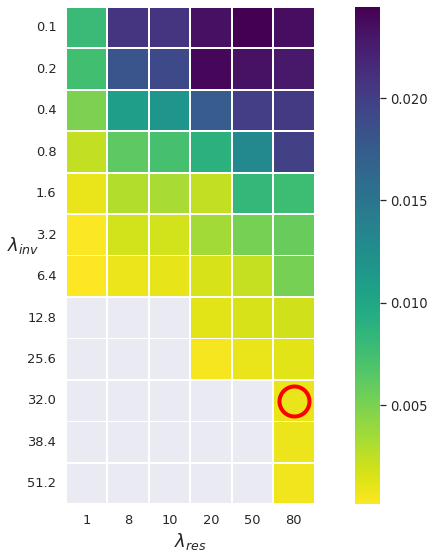

In [54]:
#### config
sns.set(font_scale=1.2)
cmap='viridis_r'  #'hot'  #'viridis'
vmax=1.6 #1.45 #1.20
vmin=0.95 #np.min(df_ratio.min())
fsize=13
lsize=18
bs=True
circle_rad = 15
x1=5.5
y1=9.5
x2=5.5
y2=10.5

fig = plt.figure(figsize=(12,8))
ax = plt.subplot(1,1,1)
sns.heatmap(deg_stdvs_df,ax=ax,cmap=cmap, square=bs,linewidths=0.75,)
ax.set_xticklabels(ax.get_xticklabels(), fontsize = fsize)
ax.set_yticklabels(lambda_inv[1:],rotation = 0, fontsize = fsize,va='center')
ax.set_ylim(len(lambda_inv[1:]),-0)
ax.set_ylabel(r'$\lambda_{inv}$', fontsize=lsize, rotation='horizontal')
ax.set_xlabel(r'$\lambda_{res}$', fontsize=lsize)
plt.subplots_adjust(bottom=0.15,left=.5)
x= np.arange(len(df_ratio.columns)+1)
y= np.arange(len(df_ratio.index)+1)
#zm = np.ma.masked_less(df_ratio.values, 1.2)
#plt.pcolor(x, y, zm, hatch='//', alpha=0.)
ax.plot(x1,y1, 'o',
        ms=circle_rad * 2, mec='red', mfc='none', mew=4)

fig.tight_layout()
#plt.subplots_adjust(hspace=0.5)
pdf = PdfPages("./figs/div_param_search_cloud2.pdf")
plt.savefig(pdf, format='pdf', bbox_inches = 'tight')
plt.show()
pdf.close()
pdf = None

Combine new + old computation results

In [273]:
infdatadir="/home/tkurihana/rotate_invariant/stepbystep/transform/inference"

In [274]:
newinfdatadir="/home/tkurihana/rotate_invariant/paper/modis_inference/inference"

In [278]:
for idx, inv in enumerate(lambda_inv):
    for jdx, res in enumerate(lambda_res):
        expname = expname_table.loc[inv,res] # float
        if np.isnan(expname):
            #deg_means_array[idx, jdx] = np.nan
            pass
        else:
            try:
                str_expname = str(int(expname))
                #print(str_expname)
                _filelist = glob.glob(os.path.join(
                    infdatadir, f"*{str_expname}*.txt"
                ))
                if len(_filelist) == 0:
                    pass
                elif len(_filelist) == 1:
                    old=_filelist[0]
                    new=os.path.join(newinfdatadir,f"inference_{str_expname}.txt")
                    shutil.copy(old, new)
                    #print("here")
                else:
                    print("multi-files",str_expname)
            except:
                pass

multi-files 66728443
